In [13]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import shutil
from PIL import Image
import scipy
import torch 
import torchvision
import torchvision.transforms as transforms
from torchvision import models , datasets
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

In [17]:
labels = pd.read_csv("data/input/train_labels.csv")

In [18]:
main_folder_path = "data/input/png_data/png_voxel_converted_ds"
main_train_folder_path = os.path.join(main_folder_path  , "train")
for subject in tqdm(os.listdir(main_train_folder_path)):
    subject_folder = os.path.join(main_train_folder_path , subject)
    for mri_type in os.listdir(subject_folder):
        mri_type_folder = os.path.join(subject_folder , mri_type)
        for mri_image in os.listdir(mri_type_folder):
            original_image_path = os.path.join(mri_type_folder , mri_image)
            mri_image = subject +"_"+ mri_type +"_"+ mri_image
            subject_num = int(subject)
            idx = np.where(labels['BraTS21ID'] == subject_num)[0][0]
            label = str(labels.loc[idx , 'MGMT_value'])
            new_image_folder_path =os.path.join("data/input" , label)
            new_image_path = os.path.join(new_image_folder_path , mri_image)
            shutil.copy(original_image_path , new_image_path)

  0%|          | 0/582 [00:00<?, ?it/s]

In [19]:
print("Images with label 0 = " , len(os.listdir("data/input/0")) , "Images with label 1 = " , len(os.listdir("data/input/1")))

Images with label 0 =  39744 Images with label 1 =  44064


In [20]:
for folder in os.listdir("data/input"):
    folder_name = str(folder)
    path = "data/input/"+folder_name
    for file in tqdm(os.listdir(path)):
        img = Image.open(path + '/' + file)
        clrs = img.getcolors()
        if len(clrs) == 1:
            os.remove(path + '/' + file)

  0%|          | 0/39744 [00:00<?, ?it/s]

  0%|          | 0/44064 [00:00<?, ?it/s]

NotADirectoryError: [WinError 267] Der Verzeichnisname ist ungültig: 'data/input/archive (7).zip'

In [21]:
print("Images with label 0 = " , len(os.listdir("data/input/0")) , "Images with label 1 = " , len(os.listdir("data/input/1")))

Images with label 0 =  31324 Images with label 1 =  34108


In [22]:
!mkdir "data/input/TRAIN"
!mkdir "data/input/TRAIN/1"
!mkdir "data/input/TRAIN/0"
!mkdir "data/input/VAL"
!mkdir "data/input/VAL/0"
!mkdir "data/input/VAL/1"
!mkdir "data/input/TEST"
!mkdir "data/input/TEST/0"
!mkdir "data/input/TEST/1"

In [23]:
IMG_PATH = "./data/input"

#split the data into train/test/val
for CLASS in tqdm(["0" , "1"]):
    IMG_NUM = len(os.listdir(IMG_PATH +"/"+ CLASS))
    for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +"/"+ CLASS)):
            img = IMG_PATH+ '/' +  CLASS + '/' + FILE_NAME
            if n <4000 :
                shutil.copy(img, 'data/input/TEST/' + str(CLASS) + '/' + FILE_NAME)
            elif n < 0.9*IMG_NUM:
                shutil.copy(img, 'data/input/TRAIN/'+ str(CLASS) + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'data/input/VAL/'+ str(CLASS) + '/' + FILE_NAME)

  0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
!rm -rf "data/input/0"
!rm -rf "data/input/1"

Der Befehl "rm" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "rm" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [28]:
len(os.listdir("data/input/TRAIN/1")) , len(os.listdir("data/input/TRAIN/0")) , len(os.listdir("data/input/VAL/1")) , len(os.listdir("data/input/VAL/0")) , len(os.listdir("data/input/TEST/1")) , len(os.listdir("data/input/TEST/0"))

(26698, 24192, 3410, 3132, 4000, 4000)

In [29]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'TRAIN': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    
    'VAL': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    
    'TEST': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [30]:
data_dir = 'data/input'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['TRAIN', 'VAL' , 'TEST']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['TRAIN', 'VAL' , 'TEST']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['TRAIN', 'VAL' , 'TEST']}
class_names = image_datasets['TRAIN'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['0', '1']


In [31]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

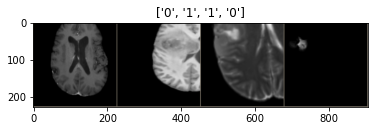

In [32]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['TRAIN']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [33]:
def train_model(model, model_name, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['TRAIN' , 'VAL']:
            if phase == 'TRAIN':
                model.train()  # Set model to training mode
            elif phase == 'VAL':
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'TRAIN'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'TRAIN':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'TRAIN':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'VAL' and epoch_acc > best_acc:
                best_acc = epoch_acc
                #save the best model
                torch.save(model , model_name+'weights.pt')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

Transfer Learning

Resnet 18

In [37]:
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features

resnet.fc = nn.Linear(num_ftrs, 2)
resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(resnet.parameters(), lr=0.001)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [38]:
train_model(resnet,"resnet", criterion, optimizer, step_lr_scheduler, num_epochs=1)

Epoch 0/0
----------
TRAIN Loss: 0.7121 Acc: 0.5146
VAL Loss: 0.7649 Acc: 0.4807

Training complete in 9m 35s
Best val Acc: 0.480740


VGG

In [40]:
vgg = models.vgg11_bn(pretrained=True)
num_ftrs = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(num_ftrs,2)

vgg = vgg.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(vgg.parameters(), lr=0.001)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [41]:
train_model(vgg,"vgg", criterion, optimizer, step_lr_scheduler, num_epochs=1)

Epoch 0/0
----------
TRAIN Loss: 0.6951 Acc: 0.5228
VAL Loss: 0.6981 Acc: 0.5028

Training complete in 16m 23s
Best val Acc: 0.502751


AlexNet

In [ ]:
alexnet = models.alexnet(pretrained=True)
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs,2)

alexnet = alexnet.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(alexnet.parameters(), lr=0.001)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
train_model(alexnet ,"alexnet", criterion, optimizer, step_lr_scheduler, num_epochs=1)